In [1]:
import numpy as np
import pandas as pd
import random, copy, os
random.seed(42)
np.random.seed(42)
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from multiprocessing import Pool
import multiprocessing

In [2]:
%run helper.ipynb

In [3]:
%run algorithm_functions.ipynb

In [4]:
plt.rcParams['font.size'] = 14
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rcParams['axes.labelsize'] = 22
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titlesize'] = 19
plt.rcParams['axes.linewidth'] = 3
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['legend.fontsize'] = 15
plt.rcParams['figure.titlesize'] = 22
plt.rcParams['lines.linewidth'] = 2.0

In [5]:
%run data_loader.ipynb

Total number of drivers: 32092, total driver types: 716
Total requests: 14486242, types of requests: 8676, total rides: 14486242
13965626
Driver Types: 82, Total Drivers: 10814
Request Types: 800, Total requests: 35109


In [6]:
driver_quota = 3
filename_append = 'quota_{}'.format(driver_quota)

## Load drivers and requests

In [7]:
drivers, requests = get_drivers_and_requests(driver_quota=driver_quota)

Chosen driver types: 20
44
b
w
b
b
b
b
b
w
b
b
123
b
w
w
b
b
b
b
b
b
b
222
b
b
b
b
b
w
b
b
b
b
1863
b
b
b
w
w
w
b
b
b
b
33
b
b
b
w
b
b
b
b
Total number of drivers: 48, Size of set U: 48
Chosen types of requests: 80
Total Sampled Requests: 2731
Initial Number of Requests: 2731.0, size of set V: 80
Final Number of Requests: 359.0 359, size of set V: 24


In [8]:
for r in requests:
    print (r.race)
for d in drivers:
    print (d.race, d.quota)

black
white
white
white
black
black
white
black
black
black
white
black
black
white
white
white
white
white
white
white
white
white
white
black
b 3
w 3
b 3
b 3
b 3
b 3
b 3
w 3
b 3
b 3
b 3
w 3
w 3
b 3
b 3
b 3
b 3
b 3
b 3
b 3
b 3
b 3
b 3
b 3
b 3
w 3
b 3
b 3
b 3
b 3
b 3
b 3
b 3
w 3
w 3
w 3
b 3
b 3
b 3
b 3
b 3
b 3
b 3
w 3
b 3
b 3
b 3
b 3


### Construct a matrix containing the edges, matrix = drivers x requests

In [9]:
probability_matrix = draw_probability_edges(drivers, requests)

In [10]:
print (np.min(probability_matrix[probability_matrix != -1]), 
       np.max(probability_matrix[probability_matrix != -1]), 
       np.mean(probability_matrix[probability_matrix != -1]))
for col in range(probability_matrix.shape[1]):
    if np.all(probability_matrix[:,col] == -1):
        print (requests[col])

0.55 0.8 0.6117857142857143


In [11]:
profit_matrix = np.zeros(probability_matrix.shape)
for i,j in zip(*np.where(probability_matrix != -1)):
    profit_matrix[i,j] = requests[j].distance
profit_matrix 

array([[0.        , 0.        , 0.06585   , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.06585   , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.06585   , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.01764699, 0.02228943,
        0.0245    ],
       [0.        , 0.        , 0.        , ..., 0.01764699, 0.02228943,
        0.0245    ],
       [0.        , 0.        , 0.        , ..., 0.01764699, 0.02228943,
        0.0245    ]])

In [12]:
(np.count_nonzero(probability_matrix != -1), np.count_nonzero(profit_matrix), 
probability_matrix.shape[0] * probability_matrix.shape[1])

(420, 420, 1152)

## In-degrees of drivers and riders

In [13]:
r_vs = []
for r in requests:
    r_vs.append(r.arrival_rate)
min(r_vs), max(r_vs)

in_degree_v = []
for i in range(len(requests)):
    in_degree_v.append(np.count_nonzero(probability_matrix[:,i] != -1))

in_degree_u = []
for i in range(len(drivers)):
    in_degree_u.append(np.count_nonzero(probability_matrix[i,:] != -1))

print ("Drivers' in-degree, average: {}, min: {}, max: {}\nRiders' in-degree, average: {}, min: {}, max: {}"\
       .format(np.mean(in_degree_u), min(in_degree_u), max(in_degree_u), 
               np.mean(in_degree_v), min(in_degree_v), max(in_degree_v)))

Drivers' in-degree, average: 8.75, min: 6, max: 10
Riders' in-degree, average: 17.5, min: 10, max: 28


### We have all variables now, use them to solve the LP

In [14]:
from cvxopt.base import matrix as m
from cvxopt import solvers
from cvxopt.modeling import op, dot, variable, max, min

In [15]:
x_f, x_fair = variable(np.count_nonzero(probability_matrix != -1)), \
    variable(np.count_nonzero(probability_matrix != -1))

### Profit Objective

In [16]:
profit, c = get_profit_objective(x_f, probability_matrix, profit_matrix)
profit

<linear function of length 1>

### Fairness Objective

In [17]:
fairness = get_fairness_objective(x_fair, probability_matrix, requests)
fairness

<convex function of length 1>

### Get LP constraints

In [18]:
inequality = get_inequalities(x_f, probability_matrix, requests)

540 540 420 420
<class 'cvxopt.modeling._function'>


In [19]:
lp_profit = op(profit, inequality)
lp_profit.solve(solver='glpk')

In [20]:
max(x_f.value), min(x_f.value)

(1.8181818181818181, 0.0)

In [21]:
inequality_fairness = get_inequalities(x_fair, probability_matrix, requests)

540 540 420 420
<class 'cvxopt.modeling._function'>


In [22]:
lp_fairness = op(fairness, inequality_fairness)
lp_fairness.solve(solver='glpk')

In [23]:
# Since we multiplied our objective by -1 and then minimized it
optimal_profit = -1 * lp_profit.objective.value()[0]
optimal_fairness = -1 * lp_fairness.objective.value()[0]
print ("When optimizing for fairness, fairness: {}, profit: {}".format(optimal_fairness, 
                                                                      -1 * dot(c, x_fair).value()[0]))
print ("When optimizing for profit, fairness: {}, profit: {}".format(
    -1 * get_fairness_objective(x_f, probability_matrix, requests).value()[0], optimal_profit))

When optimizing for fairness, fairness: 0.0826446280991736, profit: 2.698775875151419
When optimizing for profit, fairness: -0.0, profit: 7.25857723362786


In [24]:
lp_solution_sanity_check(x_f, x_fair, probability_matrix, requests)

In [25]:
print (min(x_fair.value), max(x_fair.value))
number_probes = np.zeros(probability_matrix.shape)
for i in range(len(x_fair)):
    number_probes[index_to_coordinate(i, probability_matrix)] += x_fair.value[i]
expected_probes_optimal = np.sum(number_probes, axis=0)
for i in range(len(requests)):
    expected_probes_optimal[i] /= requests[i].arrival_rate
print (expected_probes_optimal)

0.0 1.8181818181818203
[0.12714558 0.15026296 0.1147516  0.15026296 0.12714558 0.12714558
 0.15026296 0.12714558 0.12714558 0.12714558 0.10330579 0.12714558
 0.12714558 0.10655667 0.10655667 0.15026296 0.13885907 0.15026296
 0.10967854 0.15026296 0.1147516  0.10330579 0.10330579 0.12714558]


### From this point on x_f is x* and x_fair is y*

In [26]:
drivers_copy = [copy.deepcopy(d) for d in drivers] # to avoid overwriting driver values here

all_requests = []
for r in requests:
    all_requests += [r] * int(r.arrival_rate)
random.shuffle(all_requests)

# This isn't exactly correct since we need to look at "expected fairness"
exact_profit, exact_count, exact_matches = run_algorithm(all_requests, drivers_copy, probability_matrix, x_f, x_fair)
exact_fairness = measure_exact_fairness(all_requests, exact_matches)

print (exact_profit, optimal_profit, exact_count, len(all_requests))
print ("Competetive Ratio (Profit): {}, Theoretical lower bound: {}".format(
    exact_profit/optimal_profit, 0.5/np.e))
print ("Competetive Ratio (Fairness): {}, Theoretical lower bound: {}".format(
    exact_fairness/optimal_fairness, 0.5/np.e))

3.290180386711841 7.25857723362786 39 359
Competetive Ratio (Profit): 0.4532817218598911, Theoretical lower bound: 0.18393972058572117
Competetive Ratio (Fairness): 0.7117647058823525, Theoretical lower bound: 0.18393972058572117


In [27]:
alphas_0_1, alphas, betas = np.arange(0, 1.01, 0.1), np.arange(0., 1.01, 0.1), np.arange(0.,1.01,0.1)
num_loops = 1000

## Over all params

In [ ]:
# matching_results_0_1 = get_matching_results(all_requests, drivers, probability_matrix, 
#                                             x_f, x_fair, alphas_0_1, num_loops)
matching_results = get_matching_results(all_requests, drivers, probability_matrix, 
                                            x_f, x_fair, alphas, num_loops)

In [ ]:
# edges_count_results_0_1 = get_edges_count_results(all_requests, matching_results_0_1, requests)
edges_count_results = get_edges_count_results(all_requests, matching_results, requests)

In [30]:
alphas, alphas_0_1

(array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]))

In [31]:
# profit_crs_1, fairness_crs_1 = get_profit_fairness_crs(matching_results_0_1, edges_count_results_0_1, 
#                                                        num_loops, requests, alphas_0_1, optimal_profit, 
#                                                        optimal_fairness)
# print ()
profit_crs, profit_errors, fairness_crs, fairness_errors = get_profit_fairness_crs(
    matching_results, edges_count_results, num_loops, requests, alphas, optimal_profit, optimal_fairness)

TypeError: 'numpy.float64' object is not iterable

In [ ]:
print (np.sum(np.array(edges_count_results), axis=0)/num_loops, np.array([r.arrival_rate for r in requests]))
expected_fairness_nadap = (np.sum(np.array(edges_count_results), 
                                  axis=0)/num_loops)/np.array([r.arrival_rate for r in requests])
expected_fairness_nadap

In [ ]:
expected_probes_optimal

In [ ]:
assert np.min(expected_fairness_nadap) * np.e >= optimal_fairness

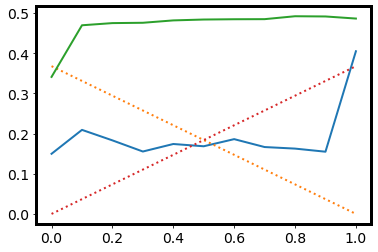

In [73]:
plt.plot(alphas, fairness_crs)
plt.plot(alphas, [x/np.e for x in 1-alphas], linestyle=':')
plt.plot(alphas, profit_crs)
plt.plot(alphas, [x/np.e for x in alphas], linestyle=':')

plt.show()

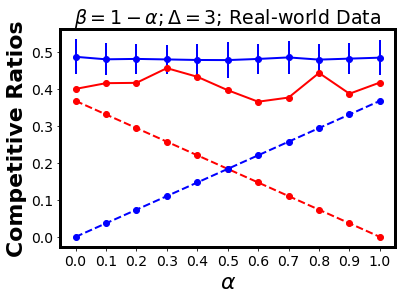

<Figure size 216x216 with 0 Axes>

In [117]:
plot_lines([fairness_crs, [x/np.e for x in 1-alphas], profit_crs, [x/np.e for x in alphas]], 
           [fairness_errors, [0 for x in alphas], profit_errors, [0 for x in alphas]],
            ["{:.1f}".format(x) for x in alphas], alphas, 
           r'$\beta = 1 - \alpha; \Delta = {}$; Real-world Data'.format(driver_quota), 
           r'$\alpha$', 'Competitive Ratios', ['-', '--', '-', '--'], ['red', 'red', 'blue', 'blue'], 
            ['NAdap (fairness)', 'Lower Bound (fairness)', 'NAdap (profit)', 'Lower Bound (profit)'], 
            'plots', 'profit_fairness_crs_vs_alpha_{}'.format(filename_append), fmt='png', separate_legend=True)

## Uniform and Greedy algorithms

In [ ]:
uniform_params, greedy_params = [], []
for i in range(num_loops):
    drivers_copy = [copy.deepcopy(d) for d in drivers]
    uniform_params.append([all_requests, drivers_copy, probability_matrix])
for i in range(num_loops):
    drivers_copy = [copy.deepcopy(d) for d in drivers]
    greedy_params.append([all_requests, drivers_copy, probability_matrix, profit_matrix])

In [ ]:
with Pool(multiprocessing.cpu_count()) as p:
    uniform_results = p.starmap(run_uniform, uniform_params)

In [ ]:
with Pool(multiprocessing.cpu_count()) as p:
    greedy_results = p.starmap(run_greedy, greedy_params)

In [74]:
greedy_profit = 0
for res in greedy_results:
    greedy_profit += res[1]
greedy_profit /= num_loops
greedy_profit_cr = greedy_profit/optimal_profit
greedy_profit_cr

0.45796831646501884

In [75]:
greedy_fairness_measure_params = []
for i in range(num_loops):
    greedy_fairness_measure_params.append([all_requests, greedy_results[i][0], requests])

with Pool(multiprocessing.cpu_count()) as p:
    greedy_edges_count_results = p.starmap(measure_fairness_edges_count, greedy_fairness_measure_params)

In [76]:
greedy_fairness_cr = calculate_fairness_from_array(greedy_edges_count_results, 
                                                   num_loops, requests)/optimal_fairness
greedy_fairness_cr

TypeError: unsupported operand type(s) for /: 'tuple' and 'float'

In [78]:
uniform_profit = 0
for res in uniform_results:
    uniform_profit += res[1]
uniform_profit /= num_loops
uniform_profit_cr = uniform_profit/optimal_profit
uniform_profit_cr

0.4753861792995502

In [79]:
uniform_fairness_measure_params = []
for i in range(num_loops):
    uniform_fairness_measure_params.append([all_requests, uniform_results[i][0], requests])

with Pool(multiprocessing.cpu_count()) as p:
    uniform_edges_count_results = p.starmap(measure_fairness_edges_count, uniform_fairness_measure_params)

In [80]:
uniform_fairness_cr = calculate_fairness_from_array(uniform_edges_count_results, 
                                                    num_loops, requests)/optimal_fairness
uniform_fairness_cr

0.44397692307692355

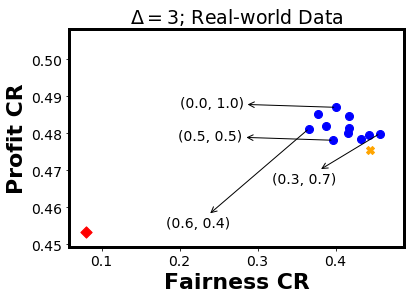

<Figure size 216x216 with 0 Axes>

In [118]:
all_x_vals = [fairness_crs , [uniform_fairness_cr], [greedy_fairness_cr]]
all_y_vals = [profit_crs, [uniform_profit_cr], [greedy_profit_cr]]
labels = [r'$NAdap (\alpha, \beta)$', 'Uniform', 'Greedy']
annotations = ['({:.1f}, {:.1f})'.format(alphas[i], 1-alphas[i]) if i == np.argmin(fairness_crs) or \
               i == np.argmax(fairness_crs) or i == np.argmin(profit_crs) or \
               i == np.argmax(profit_crs) else '' for i in range(len(alphas))] + ['', '']
annotation_positions = [(fairness_crs[i]/2 + np.ptp(fairness_crs) if '{:.1f}'.format(alphas[i]) == '0.3' else fairness_crs[i]/2, 
                         profit_crs[i] if alphas[i] == 0.5 else \
                         profit_crs[i] - i*np.ptp(profit_crs)/2) for i in range(len(alphas))]
colors = ['blue', 'orange', 'red']
shapes = ['o', 'X', 'D']
plot_scatter(all_x_vals, all_y_vals, colors, shapes, annotations, annotation_positions,
             r'$\Delta = {}$; Real-world Data'.format(driver_quota), 
             'Fairness CR', 'Profit CR', 'plots', 'fairness_vs_profit_cr_scatter_{}'.format(filename_append),
            labels=labels, fmt='png', separate_legend=True)

### For all other alpha, beta where alpha + beta < 1

In [ ]:
remaining_algorithm_params = []
values_to_offset = {}
offset = 0
for alpha_i in range(len(alphas)):
    for beta_j in range(len(betas)):
        if alphas[alpha_i] + betas[beta_j] <= 1:
            values_to_offset[(alphas[alpha_i], betas[beta_j])] = offset
            offset += 1
            for i in range(num_loops):
                remaining_algorithm_params.append([all_requests, [copy.deepcopy(d) for d in drivers],
                                                   probability_matrix, x_f, x_fair, alphas[alpha_i], betas[beta_j]])

In [ ]:
with Pool(multiprocessing.cpu_count()) as p:
    remaining_matching_results = p.starmap(run_algorithm, remaining_algorithm_params)

In [ ]:
remaining_fairness_measure_params = []
for alpha_i in range(len(alphas)):
    for beta_j in range(len(betas)):
        if (alphas[alpha_i], betas[beta_j]) in values_to_offset:
            for i in range(num_loops):
                remaining_fairness_measure_params.append([all_requests, 
                            remaining_matching_results[values_to_offset[(alphas[alpha_i], betas[beta_j])]][i][2], 
                            requests])

In [ ]:
with Pool(multiprocessing.cpu_count()) as p:
    remaining_edges_count_results = p.starmap(measure_fairness_edges_count, remaining_fairness_measure_params)

In [ ]:
for result in remaining_matching_results:
    if result[0] > 0:
        print (remaining_matching_resultsults.index(result))
        print (np.count_nonzero(result[2] != None))

In [ ]:
expected_fairness_map, expected_profit_map = np.full((len(alphas), len(betas)), np.nan), \
                                                np.full((len(alphas), len(betas)), np.nan)
for alpha_i in range(len(alphas)):
    for beta_j in range(len(betas)):
        if alphas[alpha_i] + betas[beta_j] <= 1:
            offset_index = coordinate_to_offset[(alpha_i, beta_j)]
            assert offset_index*num_loops <= len(remaining_edges_count_results) - num_loops
            
            remaining_fairness_counts = remaining_edges_count_results[offset_index * num_loops:(offset_index+1)*num_loops]
            print ((np.sum(remaining_fairness_counts, axis=0)/num_loops))
            expected_fairness_map[len(alphas) - alpha_i - 1, beta_j] = \
                calculate_fairness_from_array(remaining_fairness_counts, num_loops, requests)/optimal_fairness
            expected_profit = 0
            for i in range(num_loops):
                expected_profit += remaining_matching_results[offset_index + i][0]
            expected_profit /= num_loops
            expected_profit_map[len(alphas) - alpha_i - 1, beta_j] = expected_profit/optimal_profit
#         elif alphas[alpha_i] + betas[beta_j] == 1:
#             expected_fairness_map[len(alphas) - alpha_i - 1, beta_j] = fairness_crs[alpha_i]
#             expected_profit_map[len(alphas) - alpha_i - 1, beta_j] = profit_crs[alpha_i]

In [ ]:
expected_fairness_map, expected_profit_map

In [ ]:
plot_heatmaps([expected_profit_map], x_labels=[str("{:.1f}".format(x)) for x in betas], 
              y_labels=[str("{:.1f}".format(x)) for x in alphas[::-1]], x_title='Beta', y_title='Alpha', 
              subplot_titles=['Expected Profit (Real-world)'], subfolder='plots', 
              filename='heatmap_expected_profit_{}'.format(filename_append))
plot_heatmaps([expected_fairness_map], x_labels=[str("{:.1f}".format(x)) for x in betas], 
              y_labels=[str("{:.1f}".format(x)) for x in alphas[::-1]], x_title='Beta', y_title='Alpha', 
              subplot_titles=['Expected Fairness (Real-world)'], subfolder='plots', 
              filename='heatmap_expected_fairness_{}'.format(filename_append))

## Older functions; keeping them here just in case they're needed again

In [ ]:
e_p_1, e_p_2 = 0, 0
for result in matching_results_0:
    e_p_1 += result[0]
e_p_1 /= num_loops
e_p_2_s = []
for i in range(3):
    for result in matching_results_0_1[i*num_loops:(i+1)*num_loops]:
        e_p_2 += result[0]
    e_p_2 /= num_loops
    e_p_2_s.append(e_p_2)
e_p_1, e_p_2_s

In [ ]:
for i in range(len(matching_results_0)):
    for j in range(len(matching_results_0[i][2])):
        d1 = matching_results_0[i][2][j]
        d2 = matching_results_0_1[0:num_loops][i][2][j]
        assert d1 == d2, "{}, {}".format(d1.d_id, d2,d_id)

In [ ]:
print (calculate_fairness_from_array(edges_count_results_0, num_loops, requests))
for i in range(3):
    print (calculate_fairness_from_array(edges_count_results_0_1[i*num_loops:(i+1)*num_loops], num_loops, requests))

In [ ]:
profit_crs, fairness_crs = [], []
for j in range(len(alphas)):
    expected_profit = 0
    for i in range(num_loops):
        expected_profit += matching_results_0[j * num_loops + i][0]
        print (j * num_loops + i)
    expected_profit /= num_loops
    profit_crs.append(expected_profit/optimal_profit)
    
    print (j*num_loops, (j+1)*num_loops)
    fairness_measure = calculate_fairness_from_array(edges_count_results_0[j*num_loops:(j+1)*num_loops], 
                                                     num_loops, requests)
    print (expected_profit/optimal_profit, fairness_measure/optimal_fairness)
    fairness_crs.append(fairness_measure/optimal_fairness)

In [ ]:
profit_crs, fairness_crs = [], []
for j in range(2):
    expected_profit = 0
    for i in range(num_loops):
        expected_profit += matching_results_0_1[j * num_loops + i][0]
        print (j * num_loops + i)
    expected_profit /= num_loops
    profit_crs.append(expected_profit/optimal_profit)
    
    print (j*num_loops, (j+1)*num_loops)
    fairness_measure = calculate_fairness_from_array(edges_count_results_0_1[j*num_loops:(j+1)*num_loops], 
                                                     num_loops, requests)
    print (expected_profit/optimal_profit, fairness_measure/optimal_fairness)
    fairness_crs.append(fairness_measure/optimal_fairness)

## Calculates Expectations, not too sure if it's an entirely correct represenatation of NAdap since it isn't taking into account driver availability

In [ ]:
expected_fairness_map_nadap, expected_profit_map_nadap = np.full((len(alphas), len(betas)), np.nan), \
                                                            np.full((len(alphas), len(betas)), np.nan)
for alpha_i in range(len(alphas)):
    for beta_j in range(len(betas)):
        if alphas[alpha_i] + betas[beta_j] <= 1:
            parameters_expected_measures = []
            for r in requests:
                parameters_expected_measures.append([r, x_f, x_fair, alphas[alpha_i], betas[beta_j]])
            with Pool(multiprocessing.cpu_count()) as p:
                results_fairness = p.starmap(measure_expected_fairness, parameters_expected_measures)
            with Pool(multiprocessing.cpu_count()) as p:
                results_profit = p.starmap(measure_expected_profit, parameters_expected_measures)
            expected_fairness_map_nadap[alpha_i, beta_j] = np.min(results_fairness)
            expected_profit_map_nadap[alpha_i, beta_j] = np.sum(results_profit)

In [ ]:
plot_heatmaps([expected_profit_map_nadap], x_labels=[str("{:.1f}".format(x)) for x in betas], 
              y_labels=[str("{:.1f}".format(x)) for x in alphas], x_title='Beta', y_title='Alpha', 
              subplot_titles=['Expected Profit'], subfolder='plots', filename='heatmap_expected_profit')
plot_heatmaps([expected_fairness_map_nadap], x_labels=[str("{:.1f}".format(x)) for x in betas], 
              y_labels=[str("{:.1f}".format(x)) for x in alphas], x_title='Beta', y_title='Alpha', 
              subplot_titles=['Expected Fairness'], subfolder='plots', filename='heatmap_expected_fairness')

In [ ]:
for alpha_i in range(len(alphas)):
    x_vals, profit_vals_nadap, fairness_vals_nadap = [], [], []
    profit_vals_theory, fairness_vals_theory = [], []
    for beta_j in range(len(betas)):
        if alphas[alpha_i] + betas[beta_j] <= 1:
            profit_vals_nadap.append(expected_profit_map_nadap[alpha_i, beta_j]/optimal_profit)
            fairness_vals_nadap.append(expected_fairness_map_nadap[alpha_i, beta_j]/optimal_fairness)
            x_vals.append(betas[beta_j])
            profit_vals_theory.append(alphas[alpha_i]/np.e)
            fairness_vals_theory.append(betas[beta_j]/np.e)
    profit_vals_optimal = [1] * len(x_vals)
    fairness_vals_optimal = [1] * len(x_vals)
    plot_lines([profit_vals_theory, profit_vals_nadap, profit_vals_optimal], ["{:.1f}".format(x) for x in x_vals], 
               x_vals, 'Alpha = {}'.format(alphas[alpha_i]), 'Beta', 'Comp. Ratio (Profit)', ['--', '-', '--'], 
               ['grey', 'red', 'black'], ['Theoretical Bound', 'NAdap', 'Optimal'], 'plots', 
               'expected_profit_beta_line_plot_{:.1f}'.format(alphas[alpha_i]))
    plot_lines([fairness_vals_theory, fairness_vals_nadap, fairness_vals_optimal], 
               ["{:.1f}".format(x) for x in x_vals], x_vals, 'Alpha = {}'.format(alphas[alpha_i]), 
               'Beta', 'Comp. Ratio (Fairness)', ['--', '-', '--'], ['grey', 'red', 'black'], 
               ['Theoretical Bound', 'NAdap', 'Optimal'], 'plots', 
               'expected_fairness_beta_line_plot_{:.1f}'.format(alphas[alpha_i]))

In [ ]:
for beta_j in range(len(betas)):
    x_vals, profit_vals_nadap, fairness_vals_nadap = [], [], []
    profit_vals_theory, fairness_vals_theory = [], []
    for alpha_i in range(len(alphas)):
        if alphas[alpha_i] + betas[beta_j] <= 1:
            profit_vals_nadap.append(expected_profit_map_nadap[alpha_i, beta_j]/optimal_profit)
            fairness_vals_nadap.append(expected_fairness_map_nadap[alpha_i, beta_j]/optimal_fairness)
            x_vals.append(alphas[alpha_i])
            profit_vals_theory.append(alphas[alpha_i]/np.e)
            fairness_vals_theory.append(betas[beta_j]/np.e)
    profit_vals_optimal = [1] * len(x_vals)
    fairness_vals_optimal = [1] * len(x_vals)
    plot_lines([profit_vals_theory, profit_vals_nadap, profit_vals_optimal], ["{:.1f}".format(x) for x in x_vals], 
               x_vals, 'Beta = {}'.format(betas[beta_j]), 'Alpha', 'Comp. Ratio (Profit)', ['--', '-', '--'], 
               ['grey', 'red', 'black'], ['Theoretical Bound', 'NAdap', 'Optimal'], 'plots', 
               'expected_profit_alpha_line_plot_{:.1f}'.format(betas[beta_j]))
    plot_lines([fairness_vals_theory, fairness_vals_nadap, fairness_vals_optimal], 
               ["{:.1f}".format(x) for x in x_vals], x_vals, 'Beta = {}'.format(betas[beta_j]), 
               'Alpha', 'Comp. Ratio (Fairness)', ['--', '-', '--'], ['grey', 'red', 'black'], 
               ['Theoretical Bound', 'NAdap', 'Optimal'], 'plots', 
               'expected_fairness_alpha_line_plot_{:.1f}'.format(betas[beta_j]))

In [ ]:
fairness_map, profit_map = np.full((len(alphas), len(betas)), np.nan), np.full((len(alphas), len(betas)), np.nan)
parameters = []
for alpha_i in range(len(alphas)):
    for beta_j in range(len(betas)):
        if alphas[alpha_i] + betas[beta_j] <= 1:
            drivers_copy = [copy.deepcopy(d) for d in drivers] # to avoid overwriting driver values here
            parameters.append([all_requests, drivers_copy, alphas[alpha_i], betas[beta_j]])
print (parameters)

In [ ]:
with Pool(multiprocessing.cpu_count()) as p:
    results = p.starmap(run_algorithm, parameters)

In [ ]:
for i in range(len(results)):
    exact_profit, count, matches = results[i]
    exact_fairness = measure_exact_fairness(all_requests, matches)
    fairness_map[list(alphas).index(parameters[i][2])][list(betas).index(parameters[i][3])] = exact_fairness
    profit_map[list(alphas).index(parameters[i][2])][list(betas).index(parameters[i][3])] = exact_profit

In [ ]:
plot_heatmaps([profit_map], x_labels=[str("{:.1f}".format(x)) for x in betas], 
              y_labels=[str("{:.1f}".format(x)) for x in alphas], x_title='Beta', y_title='Alpha', 
              subplot_titles=['Profit'], subfolder='plots', filename='heatmap_profit')
plot_heatmaps([fairness_map], x_labels=[str("{:.1f}".format(x)) for x in betas], 
              y_labels=[str("{:.1f}".format(x)) for x in alphas], x_title='Beta', y_title='Alpha', 
              subplot_titles=['Fairness'], subfolder='plots', filename='heatmap_fairness')

In [ ]:
index = 0
for alpha_i in range(len(alphas)):
    x_vals, profit_vals_nadap, fairness_vals_nadap = [], [], []
    profit_vals_theory, fairness_vals_theory = [], []
    for beta_j in range(len(betas)):
        if alphas[alpha_i] + betas[beta_j] <= 1:
            print (alphas[alpha_i], betas[beta_j], index)
            exact_profit, _, matches = results[index]
            exact_fairness = measure_exact_fairness(all_requests, matches)
            profit_vals_nadap.append(exact_profit/optimal_profit)
            fairness_vals_nadap.append(exact_fairness/optimal_fairness)
            x_vals.append(betas[beta_j])
            profit_vals_theory.append(alphas[alpha_i]/np.e)
            fairness_vals_theory.append(betas[beta_j]/np.e)
            index += 1
    profit_vals_optimal = [1] * len(x_vals)
    fairness_vals_optimal = [1] * len(x_vals)
    plot_lines([profit_vals_theory, profit_vals_nadap, profit_vals_optimal], ["{:.1f}".format(x) for x in x_vals], 
               x_vals, 'Alpha = {}'.format(alphas[alpha_i]), 'Beta', 'Comp. Ratio (Profit)', ['--', '-', '--'], 
               ['grey', 'red', 'black'], ['Theoretical Bound', 'NAdap', 'Optimal'], 'plots', 
               'profit_beta_line_plot_{:.1f}'.format(alphas[alpha_i]))
    plot_lines([fairness_vals_theory, fairness_vals_nadap, fairness_vals_optimal], 
               ["{:.1f}".format(x) for x in x_vals], x_vals, 'Alpha = {}'.format(alphas[alpha_i]), 
               'Beta', 'Comp. Ratio (Fairness)', ['--', '-', '--'], ['grey', 'red', 'black'], 
               ['Theoretical Bound', 'NAdap', 'Optimal'], 'plots', 
               'fairness_beta_line_plot_{:.1f}'.format(alphas[alpha_i]))

index = 0
for beta_j in range(len(betas)):
    x_vals, profit_vals_nadap, fairness_vals_nadap = [], [], []
    profit_vals_theory, fairness_vals_theory = [], []
    for alpha_i in range(len(alphas)):
        if alphas[alpha_i] + betas[beta_j] <= 1:
            print (alphas[alpha_i], betas[beta_j], index)
            exact_profit, _, matches = results[index]
            exact_fairness = measure_exact_fairness(all_requests, matches)
            profit_vals_nadap.append(exact_profit/optimal_profit)
            fairness_vals_nadap.append(exact_fairness/optimal_fairness)
            x_vals.append(alphas[alpha_i])
            profit_vals_theory.append(alphas[alpha_i]/np.e)
            fairness_vals_theory.append(betas[beta_j]/np.e)
            index += 1
    print (profit_vals_theory)
    profit_vals_optimal = [1] * len(x_vals)
    fairness_vals_optimal = [1] * len(x_vals)
    plot_lines([profit_vals_theory, profit_vals_nadap, profit_vals_optimal], ["{:.1f}".format(x) for x in x_vals], 
               x_vals, 'Beta = {}'.format(betas[beta_j]), 'Alpha', 'Comp. Ratio (Profit)', ['--', '-', '--'], 
               ['grey', 'red', 'black'], ['Theoretical Bound', 'NAdap', 'Optimal'], 'plots', 
               'profit_alpha_line_plot_{:.1f}'.format(betas[beta_j]))
    plot_lines([fairness_vals_theory, fairness_vals_nadap, fairness_vals_optimal], 
               ["{:.1f}".format(x) for x in x_vals], x_vals, 'Beta = {}'.format(betas[beta_j]), 
               'Alpha', 'Comp. Ratio (Fairness)', ['--', '-', '--'], ['grey', 'red', 'black'], 
               ['Theoretical Bound', 'NAdap', 'Optimal'], 'plots', 
               'fairness_alpha_line_plot_{:.1f}'.format(betas[beta_j]))